In [22]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from matplotlib.lines import Line2D
from shapely.geometry import Point
import geopandas
import seaborn as sns
from scipy import stats
from imblearn import under_sampling, over_sampling 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import pairwise
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from src.data import DataLoaders
import shap

%matplotlib inline
plt.style.use('dark_background')
pd.set_option('display.max_columns',500)
sns.set()

import random

SEED = 111
random.seed(SEED)
np.random.seed(SEED)


In [23]:
ACSLoader = DataLoaders.ACSData('2016','block_group')
NFIRSLoader = DataLoaders.NFIRSData('block_group',ACSLoader.tot_pop)

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.


In [24]:
ACS = ACSLoader.data
nfirs,fires,top10 = NFIRSLoader.data, NFIRSLoader.fires, NFIRSLoader.top10

In [25]:
ACS = ACS.iloc[:,188:]

             Pair Var 1               Pair Var 2  Corr Value
188         denom_plumb              denom_kitch         1.0
134    denom_house_room           denom_house_yr         1.0
155      denom_house_yr              denom_plumb         1.0
136    denom_house_room              denom_plumb         1.0
156      denom_house_yr              denom_kitch         1.0
..                  ...                      ...         ...
109    house_pct_family     house_pct_non_family        -1.0
9      race_pct_whitenh      race_pct_nonwhitenh        -1.0
99    worked_past_12_mo  did_not_work_past_12_mo        -1.0
3        race_pct_white        race_pct_nonwhite        -1.0
125  house_pct_occupied         house_pct_vacant        -1.0

[82 rows x 3 columns]


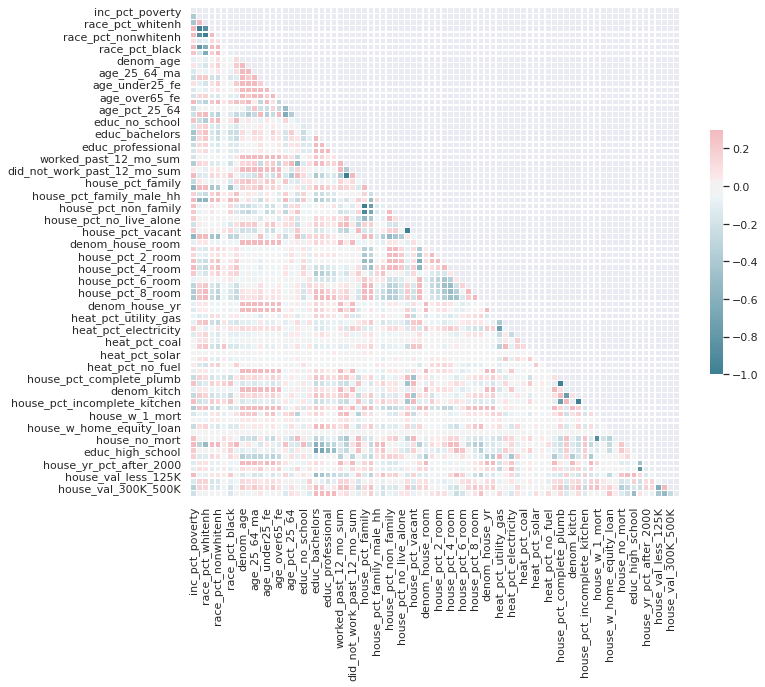

In [26]:
# Find correlated features in ACS dataset and identify the highly correlated relationships

# Create ACS correlation matrix
corr = ACS.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# Filtering out lower/upper triangular duplicates 
corr_high = corr[abs(corr) > 0.7].stack().reset_index()
corr_high = corr_high[corr_high['level_0'].astype(str)!=corr_high['level_1'].astype(str)]
corr_high['ordered-cols'] = corr_high.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
corr_high = corr_high.drop_duplicates(['ordered-cols'])
corr_high.drop(['ordered-cols'], axis=1, inplace=True)
corr_high.columns = ['Pair Var 1', 'Pair Var 2', 'Corr Value']

# Display highly correlated pairs
print(corr_high.sort_values(by=['Corr Value'], ascending=False))

# From highly correlated pairs, remove one of the Pair Vars from the ACS dataset except for the 'mort' variables
#ACS = ACS.drop(['house_pct_vacant', 'did_not_work_past_12_mo', 'house_pct_non_family', 'house_pct_ownd_occupied',
#                           'race_pct_nonwhite', 'race_pct_nonwhitenh', 'house_pct_incomplete_plumb',
#                           'house_pct_incomplete_kitchen', 'race_pct_whitenh'], axis=1) 

# Based on feature importance experiments, select features with consistence importance across annual predictions
#ACS = ACS[['house_yr_pct_earlier_1939', 'house_pct_occupied', 'house_pct_family_married', 'race_pct_black','race_pct_amind',
#          'worked_past_12_mo', 'heat_pct_fueloil_kerosene', 'educ_bachelors', 'house_pct_live_alone', 
#          'educ_some_col_no_grad', 'house_pct_ownd_occupied', 'house_w_home_equity_loan', 'house_val_175K_200K',
#           'house_val_200K_250K']]



In [27]:
# ACS munging 

ACS.loc[:,'race_pct_black_or_amind'] = ACS.loc[:,'race_pct_black'] \
                                     + ACS.loc[:,'race_pct_amind']

ACS.loc[:,'pct_alt_heat'] =  ACS.loc[:,'heat_pct_fueloil_kerosene']  \
                       + ACS.loc[:,'heat_pct_coal']   \
                       + ACS.loc[:,'heat_pct_wood']   \
                       + ACS.loc[:,'heat_pct_bottled_tank_lpgas']


ACS_reduced = ACS.copy()
ACS_reduced = ACS_reduced[[
                            'did_not_work_past_12_mo',
                            'house_pct_live_alone',
                            'pct_alt_heat',
                            'house_yr_pct_before_1960',
                            'inc_pct_poverty',
                            'race_pct_black_or_amind'
                            ]]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
ACS_reduced

,did_not_work_past_12_mo,house_pct_live_alone,pct_alt_heat,house_yr_pct_before_1960,inc_pct_poverty,race_pct_black_or_amind
GEOID,,,,,,
010010201001,0.355019,0.221831,0.017606,0.221831,0.191946,0.214765
010010201002,0.309021,0.127193,0.032895,0.079229,0.044269,0.082213
010010202001,0.509589,0.344560,0.000000,0.135678,0.382199,0.591667
010010202002,0.309886,0.338496,0.019912,0.235772,0.111426,0.461974
010010203001,0.294054,0.276699,0.000000,0.030303,0.042301,0.227157
...,...,...,...,...,...,...
560459511001,0.301663,0.324047,0.366569,0.308305,0.094029,0.000000
560459511002,0.288010,0.258713,0.825737,0.197500,0.062579,0.014547
560459513001,0.232123,0.330784,0.105163,0.556757,0.261512,0.000000


In [29]:
# function to create histogram of with # of fires on x-axis and # of census blocks on y-axis
def plotFires(df):

    figsize = (20, 16)
    cols = 4
    rows = 2
    f, axs = plt.subplots(cols,rows,figsize= figsize)


    cases = df.columns.to_list()
    for  case in enumerate(cases):
        ax = plt.subplot(cols,rows,case[0]+1)
        ax.set_title('All Fires {}'.format(str(case[1])) )
        plt.hist(df[case[1]],bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,20,40,80,100])
        

In [30]:
# Function to upsample or downsample our dataframe features if we have unbalanced classes

def resample_df(X,y,upsample=True,seed = SEED):
    from sklearn.utils import resample
    # check which of our two classes is overly represented 
    if np.mean(y) > .5:
        major,minor = 1,0
    else:
        major,minor = 0, 1
    
    # Add Class feature to dataframe equal to our existing dependent variable
    X['Class'] = y
    
    df_major = X[X.Class == major ]
    df_minor = X[X.Class == minor ]
    

    if upsample:      
    
        df_minor_resampled = resample(df_minor,
                                     replace = True,
                                     n_samples = df_major.shape[0], 
                                     random_state = seed)
    
    
   
        combined = pd.concat([df_major,df_minor_resampled])
        
        # Debug
        #print('minor class {}, major class {}'.format(df_minor_resampled.shape[0],
                                                       #df_major.shape[0]))
    
        
    else: # downsample
         
        df_major_resampled = resample(df_major,
                                     replace = False,
                                     n_samples = df_minor.shape[0],
                                     random_state = seed)
        
        
        combined = pd.concat([df_major_resampled,df_minor])
        
        #print('minor class {}, major class {}'.format(df_minor.shape[0],
                                                      #df_major_resampled.shape[0]))


    
    
    y_out = combined['Class']
    X_out = combined.drop('Class', axis =1)
    return X_out , y_out

In [31]:
def munge_dataset(top10,fires,ACS,n_years,test_year):    
    years = top10.columns
    test_loc = years.get_loc(str(test_year))
    
      # convert format for consistent output
    X =  fires.iloc[:,test_loc-n_years:test_loc].copy()
    
    #X.columns = ['year-{}'.format(n_years-1 - year) for year in range(n_years-1)]

    #sm = np.nansum(X, axis = 1 )
    #mu = np.nanmean(X, axis = 1)
    mx = np.nanmax(X, axis =1)
    md = np.nanmedian(X,axis =1 )
    X['Median'] = md  
    #X['Sum']  = sm
    #X['Mean'] = mu
    X['Max']  = mx
    
    
    
   
    
    y  = top10.iloc[:,test_loc]
    
   



    # merge in ACS Data into X unless NFIRS-Only model
    out_fires = []
    if not ACS.empty:
        
        # save copy for manual validation
        out_fires = X.copy().merge(ACS, how ='left',left_index = True, right_index = True)
        
        X=X[['Max','Median']] # drop all other NFIRS columns that have low feature importance scores
        X = X.merge(ACS, how ='left',left_index = True, right_index = True)
        
        
        
        

    
    
    return X,y,out_fires 

In [32]:
# Function to train model that predicts whether each census block is in the top 10% percent of fire risk scores
def train_model(top10,fires, ACS = pd.DataFrame(), n_years = 5, modeltype='LogisticRegression',test_year=2016, seed = SEED):
    from scipy.stats import zscore
    
    predict = False 
    # Define model types & parameters 
    
    if modeltype =='LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(warm_start=True,
                                   class_weight = 'balanced',
                                   max_iter = 1000)

        
    elif modeltype =='BalBagged':
        from imblearn.ensemble import BalancedBaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                          n_estimators=80, sampling_strategy='auto',
                                          random_state=0,
                                          n_jobs = -1)
        
    elif modeltype =='BalRF':
        from imblearn.ensemble import BalancedRandomForestClassifier
        model = BalancedRandomForestClassifier(n_estimators=80, sampling_strategy='auto',
                                               max_depth=10, random_state=0,
                                              max_features=None, min_samples_leaf=40,
                                              n_jobs = -1)

    elif modeltype =='Bagged':
        from sklearn.ensemble import BaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    n_estimators=40,
                                    random_state=0)
    
    elif modeltype =='RF':
        from imblearn.ensemble import BalancedRandomForestClassifier
        model = BalancedRandomForestClassifier(n_estimators=60,
                                          warm_start = False,
                                          max_depth = 10,
                                        random_state = 0)
        
        
    elif modeltype =='XGBoost':
        from xgboost import XGBClassifier 
        model = XGBClassifier( n_estimators=60,
                    max_depth=10,
                    random_state=0,
                    max_features = None,
                    n_jobs = -1, 
                    seed = SEED )
        
    
    
    # Create framework to predict whether a given census block has a fire risk score in the 90th percentile 
            # based on the specific number of previous years' data
        
    years = top10.columns
    Model_Input = None
    Model_Predictions = None
    Model_Prediction_Probs = None
    Model_Actual = None
    
    
    if test_year == 'Current':
        predict = True 
        test_year = fires.columns[-1]
               
    # each model will train on 4 years of data to predict the locations subsequent year with highest fire risk 
    # model will train predicting 1 year and then test model accuracy by predicting the next year 
    
    # for example: 
    
    #  Train 
    # predict 2016 using 2015-2012 data 
    #
    #
    #  Test
    # predict 2017 using 2016-2015 data  
   
    

    X_train, y_train,_ = munge_dataset(top10,fires,ACS,n_years,test_year-1)
    
    X_test, y_test,Input = munge_dataset(top10,fires,ACS,n_years,test_year)
    
    # Note: `Input` is used for manual data validation to ensure munging performed correctly 
     

    # Create 80/20 training/testing set split
    #X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2 )

    # Perform resampling if data classes are unbalanced
    X_train, y_train = resample_df(X_train,y_train,upsample = False)



    # Standardize features by removing the mean and scaling to unit variance

    # scaler = preprocessing.StandardScaler().fit(X_train)
    # X_train= scaler.transform(X_train)
    # X_test = scaler.transform(X_test)


    # Fit model to training set

    print('Predicting {}:'.format(str(test_year)) )
    model = model.fit(X_train,y_train)


    # Calculate training set performance

    #train_prediction_probs = model.predict_proba(X_train)
    #train_predictions = model.predict(X_train)
    #print (confusion_matrix(y_train, train_predictions))
    #print (roc_auc_score(y_train, train_prediction_probs[:,1]))


    # Calculate test set performance

    test_prediction_probs = model.predict_proba(X_test)
    test_predictions = model.predict(X_test)
    #Model_Predictions = pd.Series(test_predictions)
    #Model_Prediction_Probs = pd.Series(test_prediction_probs[:,[1]].flatten())
    print (confusion_matrix(y_test, test_predictions))
    print (roc_auc_score(y_test, test_prediction_probs[:,1]))
    print (classification_report(y_test,test_predictions))
    print (log_loss(y_test,test_predictions))


    #Calculate feature importance for each model

    if modeltype=="LogisticRegression":
        feature_importance = {}
        for coef, feat in zip(abs(model.coef_[0]),X_test.columns.tolist()):
            feature_importance[feat] = coef
        print("Feature ranking:")
        print (feature_importance)
    else:
        if modeltype=="RF" or modeltype=="BalRF":
            importances = model.feature_importances_
        elif modeltype=="Bagged":
            importances = np.mean([model.estimators_[i].feature_importances_ for i 
                           in range(len(model.estimators_))], axis=0)
        elif modeltype=="BalBagged":
            importances = np.mean([model.estimators_[i].steps[1][1].feature_importances_ for i 
                           in range(len(model.estimators_))], axis=0)
        elif modeltype =='XGBoost':
                importances = model.feature_importances_

        indices = np.argsort(importances)[::-1]
        print("Feature ranking:")
        for f in range(len(X_test.columns)):
            print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]]))
     
    
                                                                # to fix 
    return model,X_test,y_test,Input,test_predictions,test_prediction_probs[:,1],test_predictions
        


In [33]:
ACS_reduced

,did_not_work_past_12_mo,house_pct_live_alone,pct_alt_heat,house_yr_pct_before_1960,inc_pct_poverty,race_pct_black_or_amind
GEOID,,,,,,
010010201001,0.355019,0.221831,0.017606,0.221831,0.191946,0.214765
010010201002,0.309021,0.127193,0.032895,0.079229,0.044269,0.082213
010010202001,0.509589,0.344560,0.000000,0.135678,0.382199,0.591667
010010202002,0.309886,0.338496,0.019912,0.235772,0.111426,0.461974
010010203001,0.294054,0.276699,0.000000,0.030303,0.042301,0.227157
...,...,...,...,...,...,...
560459511001,0.301663,0.324047,0.366569,0.308305,0.094029,0.000000
560459511002,0.288010,0.258713,0.825737,0.197500,0.062579,0.014547
560459513001,0.232123,0.330784,0.105163,0.556757,0.261512,0.000000


In [34]:
# Train NFIRS Only Model and output prediction performance metrics for each year
# mdl,X_test,y_test=train_model(top10.loc[:,'2009':'2016'],fires,nyears = 5, modeltype='RF', resample = True)

# Train NFIRS + ACS Model and output prediction performance metrics for each year
mdl,X_test,y_test,Input,Predictions,Prediction_Probs,Actuals =train_model(top10.loc[:,'2009':'2017'],fires,ACS = ACS,n_years=5,test_year = 2017, modeltype='XGBoost')

All-NaN axis encountered
All-NaN slice encountered


Predicting 2017:
[[148960  42501]
 [  2403   8919]]
0.8690017448745613
              precision    recall  f1-score   support

       False       0.98      0.78      0.87    191461
        True       0.17      0.79      0.28     11322

    accuracy                           0.78    202783
   macro avg       0.58      0.78      0.58    202783
weighted avg       0.94      0.78      0.84    202783

7.648388666345061
Feature ranking:
1. Max (0.137412)
2. Median (0.041958)
3. worked_past_12_mo_sum (0.026866)
4. denom_age (0.023851)
5. heat_pct_fueloil_kerosene (0.022729)
6. pct_alt_heat (0.017605)
7. denom_house_mort (0.013883)
8. house_pct_family (0.013708)
9. house_w_both_2_mort_and_loan (0.013619)
10. race_pct_black (0.013113)
11. age_25_64_fe (0.012901)
12. house_val_less_125K (0.012784)
13. house_pct_family_married (0.012625)
14. heat_pct_wood (0.012433)
15. house_pct_1_room (0.012190)
16. inc_pct_poverty (0.012109)
17. race_pct_hisp (0.011864)
18. race_pct_whitenh (0.011795)
19. heat_p

In [35]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X_test,y_test,approximate = True)

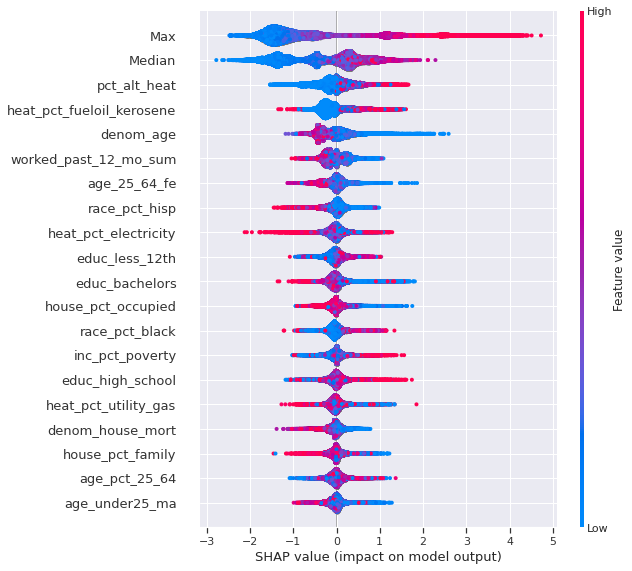

In [36]:
shap.summary_plot(shap_values,X_test, feature_names = X_test.columns)

In [37]:
# Train NFIRS Only Model and output prediction performance metrics for each year
# mdl,X_test,y_test=train_model(top10.loc[:,'2009':'2016'],fires,nyears = 5, modeltype='RF', resample = True)

# Train NFIRS + ACS Model and output prediction performance metrics for each year
mdl,X_test,est,Input,Predictions,Prediction_Probs,Actuals  =train_model(top10.loc[:,'2009':'2017'],fires,ACS = ACS_reduced,n_years=5,test_year = 2017, modeltype='XGBoost')

All-NaN axis encountered
All-NaN slice encountered


Predicting 2017:
[[147548  43913]
 [  2484   8838]]
0.8605174965557221
              precision    recall  f1-score   support

       False       0.98      0.77      0.86    191461
        True       0.17      0.78      0.28     11322

    accuracy                           0.77    202783
   macro avg       0.58      0.78      0.57    202783
weighted avg       0.94      0.77      0.83    202783

7.902687706152011
Feature ranking:
1. Max (0.389780)
2. Median (0.158296)
3. pct_alt_heat (0.086242)
4. house_pct_live_alone (0.079018)
5. race_pct_black_or_amind (0.073955)
6. house_yr_pct_before_1960 (0.072403)
7. inc_pct_poverty (0.072039)
8. did_not_work_past_12_mo (0.068267)


In [38]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X_test,y_test,approximate = True)

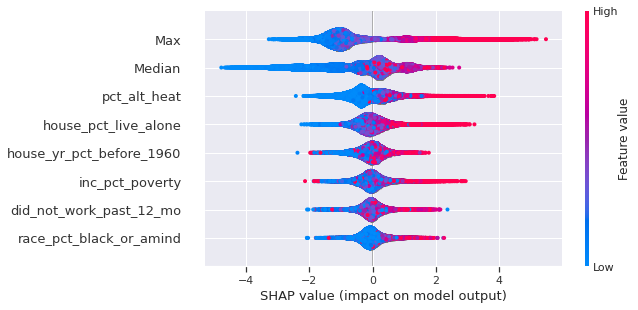

In [39]:
shap.summary_plot(shap_values,X_test, feature_names = X_test.columns)

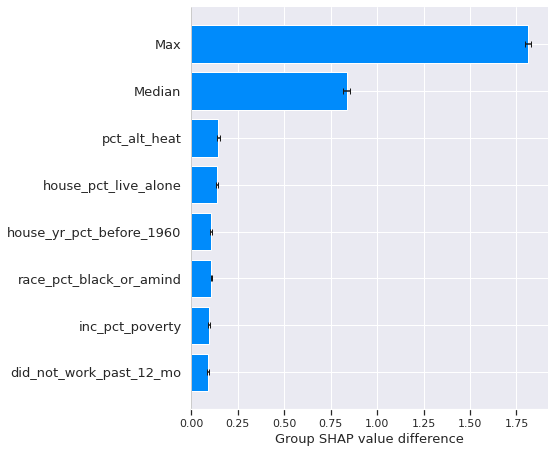

In [40]:
shap.group_difference_plot(shap_values,y_test,feature_names = X_test.columns)

In [41]:
Input['True_Labels']=Actuals
Input['Predicted_Labels']=Predictions
Input['Predicted_Probs']=Prediction_Probs
Input['GEOID']=list(Input.index)


In [42]:
# Extract GEOIDs of census blocks that were not present in the nfirs dataset
missing_GEOIDS_df = ACS[~ACS.index.isin(nfirs.index.tolist())]
missing_GEOIDS=set(missing_GEOIDS_df.index)


missing_GEOIDS_df=missing_GEOIDS_df[['did_not_work_past_12_mo',
                            'house_pct_live_alone',
                            'pct_alt_heat',
                            'house_yr_pct_before_1960',
                            'inc_pct_poverty',
                            'race_pct_black_or_amind']]
missing_GEOIDS_df['True_Labels']=0
missing_GEOIDS_df['Predicted_Labels']=0
missing_GEOIDS_df['Predicted_Probs']=0
missing_GEOIDS_df['GEOID']=list(missing_GEOIDS_df.index)

New_Input=pd.concat([Input,missing_GEOIDS_df],ignore_index=False)
New_Input['GEOID']  = '#_' + New_Input['GEOID']
New_Input.set_index('GEOID',inplace = True)


In [ ]:
out_path = utils.DATA['model-outputs']

New_Input.to_csv( out_path / 'PropensityBlockModel.csv')

In [ ]:
New_Input.index.str[2:4].value_counts()

In [ ]:
# Function to visualize relative feature importance for trained Logistic Regression models
def plot_LR_feat_importance(model):
    # Calculate and store relative importance of model features
    feature_importance = {}
    for coef, feat in zip(abs(model.coef_[0]),X_test.columns.tolist()):
        feature_importance[feat] = coef
    data_to_plot = pd.DataFrame.from_dict(features,orient ='index').reset_index()
    data_to_plot.columns = ['Variables','Importance Coefficients']
    data_to_plot = data_to_plot.sort_values('Importance Coefficients', ascending=False )
    data_to_plot = data_to_plot[0:10]

    plt.figure(figsize=(16, 8))
    sns.barplot(
        x='Variables', y='Importance Coefficients',
        data=data_to_plot, palette='Blues_r')
    plt.xticks(
        range(len(data_to_plot)),
        data_to_plot['Variables'], rotation='45', size=10)
    plt.xlabel('Variables', fontsize=30)
    plt.ylabel('Coeff', fontsize=30)
    plt.tight_layout()
    plt.show()
    

In [ ]:
# Display list of relative feature importance for RF models
def rf_feat_importance(model, num_feats_to_display):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(num_feats_to_display):
        print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]]))

In [ ]:
# Function to visualize example tree from random forest (only functional if model max_depth<=5)
def plot_rf_tree(model):
    estimator = model.estimators_[1]
    from sklearn import tree
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
    tree.plot_tree(estimator,
               feature_names = X_test.columns, 
               class_names=y_test.index.name,
               filled = True);
    fig.savefig('rf_individualtree.png')

In [ ]:
def process_data(X,y, test_size=0.2, seed=SEED):
    
    from scipy.stats import zscore
    
    
    X = np.log(X +1)
    y = np.log(y+1)
    
    print (X.shape)
   # rename features and add new features
    X.columns = ['year-{}'.format(year[0]+1) for year in enumerate(X.columns)]
    X.columns
    X['Sum'] = np.sum(X, axis = 1 )
    X['mean']= np.mean(X, axis = 1)
    X['median'] = np.median(x, axis = 1)
    
    
    X = zscore(X.astype(float), axis=0)
    
    
 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)
    
    return X_train, X_test, y_train, y_test